# In this notebook, we extract financial data, and do some simple data manipulations

In [264]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime 
import quandl 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import edhec_risk_kit_206 as erk
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Extracting from the pandas_datareader API
aapl = web.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 1, 31))
aapl.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-12-31,12.534286,12.191428,12.281428,12.192857,151885300.0,10.609017
2009-01-02,13.005714,12.165714,12.268572,12.964286,186503800.0,11.280237
2009-01-05,13.740000,13.244286,13.310000,13.511429,295402100.0,11.756306
2009-01-06,13.881429,13.198571,13.707143,13.288571,322327600.0,11.562399
2009-01-07,13.214286,12.894286,13.115714,13.001429,188262200.0,11.312555


In [57]:
# Extracting from the quandl API
# my quandl API key: <>
aapl = quandl.get("WIKI/AAPL", start_date="2009-01-01", end_date="2018-01-31") #api_key="quandl_API_key")
aapl.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2009-01-02,85.88,91.04,85.16,90.75,26643400.0,0.0,1.0,11.036777,11.699909,10.944247,11.662640,186503800.0
2009-01-05,93.17,96.18,92.71,94.58,42200300.0,0.0,1.0,11.973644,12.360471,11.914527,12.154848,295402100.0
2009-01-06,95.95,97.17,92.39,93.02,46046800.0,0.0,1.0,12.330912,12.487699,11.873403,11.954366,322327600.0
2009-01-07,91.81,92.50,90.26,91.01,26894600.0,0.0,1.0,11.798865,11.887539,11.599668,11.696053,188262200.0
2009-01-08,90.43,93.15,90.04,92.70,24053600.0,0.0,1.0,11.621515,11.971073,11.571395,11.913242,168375200.0


In [33]:
# A third way could be to simply download the data directly from a DataBase like Yahoo Finance, and import it as pd.read_csv

In [58]:
# for now we only want the adjusted close and adjusted volume
aapl = aapl[["Adj. Close", "Adj. Volume"]]
aapl.head()

,Adj. Close,Adj. Volume
Date,,
2009-01-02,11.662640,186503800.0
2009-01-05,12.154848,295402100.0
2009-01-06,11.954366,322327600.0
2009-01-07,11.696053,188262200.0
2009-01-08,11.913242,168375200.0


### Create a 100 day simple moving average

This calculates the average from the the current day and the past 99 days, moving from day nr. 100 until the last day in the dataset.

In [59]:
aapl_100MA = aapl["Adj. Close"].rolling(window=100).mean()
aapl["100MA"] = aapl_100MA

### Plot the Apple price and volume

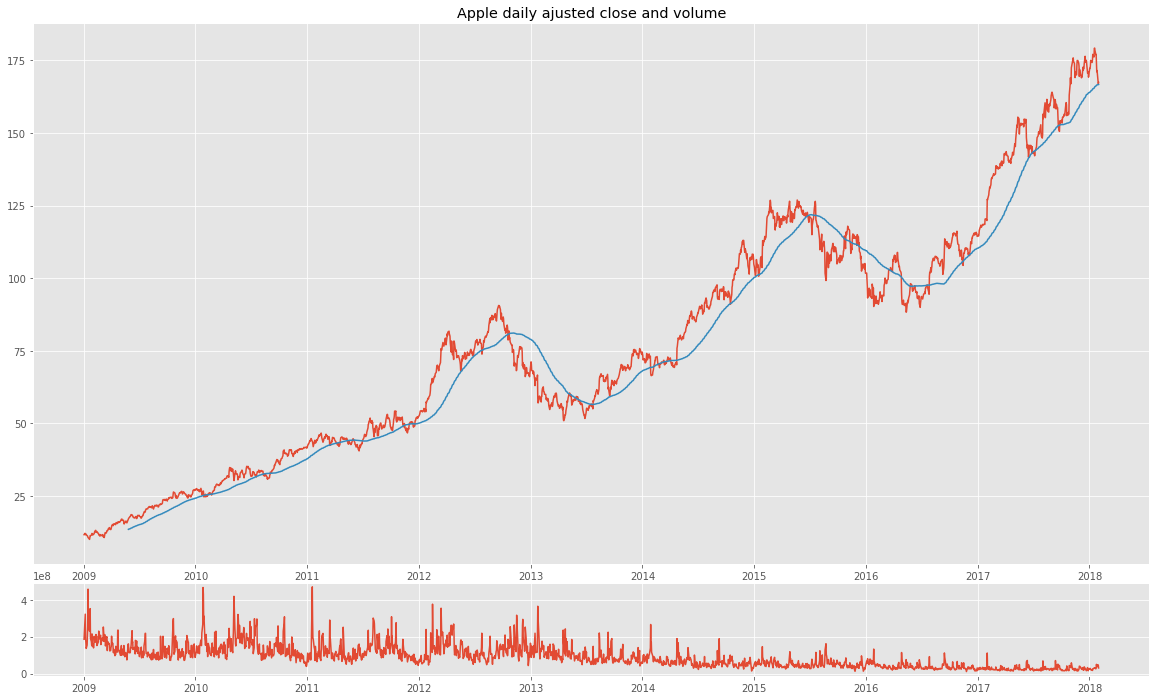

In [60]:
fig = plt.figure(figsize=(20,12))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1,  title="Apple daily ajusted close and volume")
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=5, colspan=1, sharex=ax1)

ax1.plot(aapl.index, aapl["Adj. Close"])
ax1.plot(aapl.index, aapl["100MA"])
ax2.plot(aapl.index, aapl["Adj. Volume"])

plt.show()

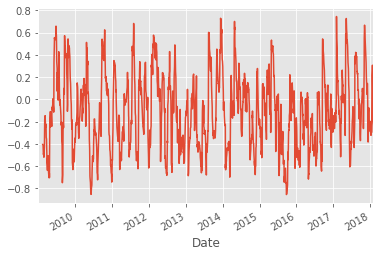

In [61]:
# rolling correlation between adjusted close and adjusted volume
# first normalize volume to be equal to Adj close at the starting time
factor = aapl["Adj. Volume"]/aapl["Adj. Close"]
rolling_corr = aapl["Adj. Close"].rolling(window=30).corr(aapl["Adj. Volume"]/factor[0])
rolling_corr.plot()

### test for stationarity

In [62]:

import statsmodels
from statsmodels.tsa.stattools import adfuller
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print("p-value =", pvalue, ' The series is likely stationary.')
        return True
    else:
        print("p-value =", pvalue, ' The series is likely non-stationary.')
        return False

In [63]:
check_for_stationarity(rolling_corr.dropna())

p-value = 1.0312019047795134e-14  The series is likely stationary.


True

### Buy and hold when the moving average slopes up, sell and hold bond or short when it slopes down

In [64]:
aapl_100MA.dropna(inplace=True)

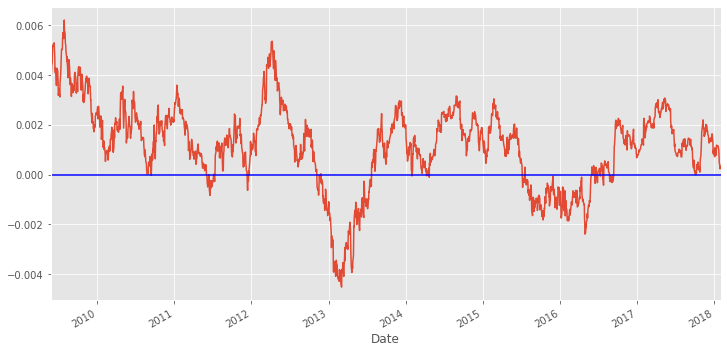

In [65]:
# Calculate the return series of the 100 day moving average
# when this goes negative, the slope of the MA will be negative
aapl_100MA_ret = (aapl_100MA - aapl_100MA.shift())/aapl_100MA.shift()
aapl_100MA_ret.dropna(inplace=True)
ax = aapl_100MA_ret.plot(figsize=(12,6))
ax.axhline(y=0, color="blue")
plt.show()

### Repeating the previous DataFrame manipulation steps, and adding a new column of the price process of the long/short strategy, where we go long if the 100 day moving average is sloping upwards, and go short if the 100 day MA is sloping downwards

In [200]:
aapl = quandl.get("WIKI/AAPL", start_date="2009-01-01", end_date="2018-01-31", api_key="qzsdYMqzoj22bPxagjfK")
aapl = aapl[["Adj. Close", "Adj. Volume"]]
aapl["Return"] = (aapl["Adj. Close"] - aapl["Adj. Close"].shift())/aapl["Adj. Close"].shift()
aapl["Adj. Close diff"] = aapl["Adj. Close"]
aapl_100MA = aapl["Adj. Close"].rolling(window=100).mean()
aapl["100MA"] = aapl_100MA

# Add a new column to aapl that gives the position we should hold
aapl = aapl.dropna()

aapl_100MA_ret = (aapl_100MA - aapl_100MA.shift())/aapl_100MA.shift()
aapl_100MA_ret.dropna(inplace=True)
aapl["100MA return"] = aapl_100MA_ret


# True if 100MA slopes down
aapl["Position"] = "nan" 
# add long short strategy column
aapl["longshort"] = 0
aapl["longshort"][0] = aapl["Adj. Close"][0]
# add long hold strategy column
aapl["longcash"] = 0
aapl["longcash"][0] = aapl["Adj. Close"][0]
#aapl = aapl[1:]

x = -0.0001

# Long/short strategy will add up the return of the price if we are long, and subtract the returns when we are short
# long/cash strategy will go long if the 100 day moving average is sloping upwards, and sell and hold cash if the 100 day MA
# is sloping downwards
count = 1
aapl_diff = aapl["Adj. Close"].diff()
for i in range(0,aapl.shape[0]):
    if aapl["100MA return"][i] <= x:
        aapl.Position.iloc[[i]] = "Short"
        if count < aapl.shape[0]:
            aapl.longshort.iloc[[i+1]] = aapl["longshort"][i] - aapl_diff[i+1]
            aapl.longcash.iloc[[i+1]] = aapl["longcash"][i]
    else:
        aapl.Position.iloc[[i]] = "Long"
        if count < aapl.shape[0]:
            aapl.longshort.iloc[[i+1]] = aapl["longshort"][i] + aapl_diff[i+1]
            aapl.longcash.iloc[[i+1]] = aapl["longcash"][i] + aapl_diff[i+1]
    count = count + 1

aapl

C:\Users\Runar\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Runar\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Adj. Close,Adj. Volume,Return,Adj. Close diff,100MA,100MA return,Position,longshort,longcash
Date,,,,,,,,,
2009-05-27,17.098779,161605500.0,0.017357,17.098779,13.520809,NaN,Long,17.000000,17.000000
2009-05-28,17.358378,121888200.0,0.015182,17.358378,13.577767,0.004213,Long,17.259598,17.259598
2009-05-29,17.453478,114133600.0,0.005479,17.453478,13.630753,0.003902,Long,17.354698,17.354698
2009-06-01,17.908417,113124900.0,0.026066,17.908417,13.690294,0.004368,Long,17.809638,17.809638
2009-06-02,17.926409,114055900.0,0.001005,17.926409,13.752597,0.004551,Long,17.827630,17.827630
...,...,...,...,...,...,...,...,...,...
2018-01-25,171.110000,39661804.0,-0.017851,171.110000,166.503778,0.000466,Long,183.696447,177.353834
2018-01-26,171.510000,37121805.0,0.002338,171.510000,166.578878,0.000451,Long,184.096447,177.753834
2018-01-29,167.960000,48434424.0,-0.020699,167.960000,166.617978,0.000235,Long,180.546447,174.203834


### Plot the three price processes

* 1: Buy and hold apple stock through the entire period
* 2: Buy and hold when the 100d MA is sloping upwards, sell and hold cash when it is sloping downwards
* 3: Buy and hold when the 100d MA is sloping upwards, sell and short when it is sloping downwards

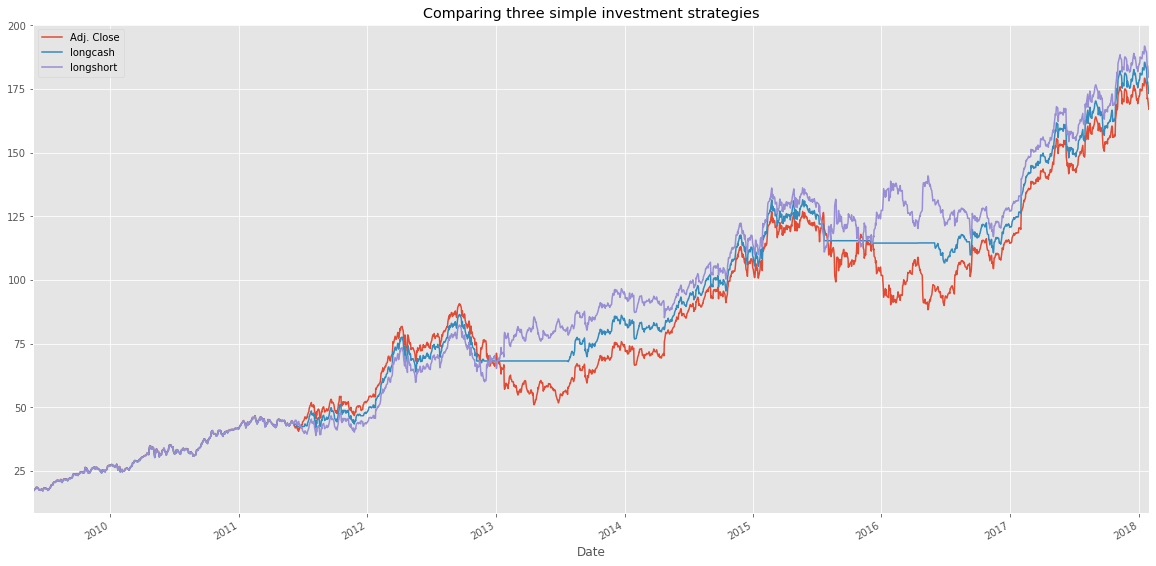

In [217]:
ax = aapl[["Adj. Close", "longcash", "longshort"]].plot(figsize=(20,10), title="Comparing three simple investment strategies")

### Repeat the same test, but now create a general function that does the same where we can import whichever time series we'd like

In [425]:
def investment_strategies_quandl(ticker, start, end, x=0):
    """
    Insert ticker, start time, end time, the function will use the quandl API to extract a DataFrame of the given ticker
    and the given time frame. It will then create three investment strategies. One buy and hold, one buy and hold when
    the 100 day MA is sloping upward, and short sell when it is sloping downward.
    The third strategy will hold cash instead of short selling.
    x: long/short trigger point
    """
    
    df = quandl.get(f"WIKI/{ticker}", start_date=start, end_date=end, api_key="qzsdYMqzoj22bPxagjfK")
    df = df[["Adj. Close", "Adj. Volume"]]
    df["Return"] = (df["Adj. Close"] - df["Adj. Close"].shift())/df["Adj. Close"].shift()
    df_100MA = df["Adj. Close"].rolling(window=100).mean()
    df["100MA"] = df_100MA

    # Add a new column to aapl that gives the position we should hold
    df = df.dropna()

    df_100MA_ret = (df_100MA - df_100MA.shift())/df_100MA.shift()
    df_100MA_ret.dropna(inplace=True)
    df["100MA return"] = df_100MA_ret

    # True if 100MA slopes down
    df["Position"] = "nan" 
    # add long short strategy column
    df["longshort"] = 0
    df["longshort"][0] = df["Adj. Close"][0]
    # add long hold strategy column
    df["longcash"] = 0
    df["longcash"][0] = df["Adj. Close"][0]

    # Long/short strategy will add up the return of the price if we are long, and subtract the returns when we are short
    # long/cash strategy will go long if the 100 day moving average is sloping upwards, and sell and hold cash if the 100 day MA
    # is sloping downwards
    count = 1
    df_diff = df["Adj. Close"].diff()
    for i in range(0,df.shape[0]):
        if df["100MA return"][i] <= x:
            df.Position.iloc[[i]] = "Short"
            if count < df.shape[0]:
                df.longshort.iloc[[i+1]] = df["longshort"][i] - df_diff[i+1]
                df.longcash.iloc[[i+1]] = df["longcash"][i]
        else:
            df.Position.iloc[[i]] = "Long"
            if count < df.shape[0]:
                df.longshort.iloc[[i+1]] = df["longshort"][i] + df_diff[i+1]
                df.longcash.iloc[[i+1]] = df["longcash"][i] + df_diff[i+1]
        count = count + 1
        
    r1 = (df["Adj. Close"] - df["Adj. Close"].shift())/df["Adj. Close"].shift()
    r2 = (df["longcash"] - df["longcash"].shift())/df["longcash"].shift()
    r3 = (df["longshort"] - df["longshort"].shift())/df["longshort"].shift()
    df_return = pd.DataFrame({"return":r1, "return longcash":r2, "return longshort":r3})
    df_return.dropna(inplace=True)
    
    return (df, df_return)


def investment_strategies(df, ticker, start, end, x=0):
    """
    Insert ticker, start time, end time, and a DataFrame. The DataFrame needs to contain a price column names "Price"
    It will then create three investment strategies. One buy and hold, one buy and hold when
    the 100 day MA is sloping upward, and short sell when it is sloping downward.
    The third strategy will hold cash instead of short selling.
    x: long/short trigger point
    """
    df = df[start:end]
    df["Return"] = (df["Price"] - df["Price"].shift())/df["Price"].shift()
    df_100MA = df["Price"].rolling(window=100).mean()
    df["100MA"] = df_100MA

    # Add a new column to aapl that gives the position we should hold
    df = df.dropna()

    df_100MA_ret = (df_100MA - df_100MA.shift())/df_100MA.shift()
    df_100MA_ret.dropna(inplace=True)
    df["100MA return"] = df_100MA_ret


    # True if 100MA slopes down
    df["Position"] = "nan" 
    # add long short strategy column
    df["longshort"] = 0
    df["longshort"][0] = df["Price"][0]
    # add long hold strategy column
    df["longcash"] = 0
    df["longcash"][0] = df["Price"][0]


    # Long/short strategy will add up the return of the price if we are long, and subtract the returns when we are short
    # long/cash strategy will go long if the 100 day moving average is sloping upwards, and sell and hold cash if the 100 day MA
    # is sloping downwards
    count = 1
    df_diff = df["Price"].diff()
    for i in range(0,df.shape[0]):
        if df["100MA return"][i] <= x:
            df.Position.iloc[[i]] = "Short"
            if count < df.shape[0]:
                df.longshort.iloc[[i+1]] = df["longshort"][i] - df_diff[i+1]
                df.longcash.iloc[[i+1]] = df["longcash"][i]
        else:
            df.Position.iloc[[i]] = "Long"
            if count < df.shape[0]:
                df.longshort.iloc[[i+1]] = df["longshort"][i] + df_diff[i+1]
                df.longcash.iloc[[i+1]] = df["longcash"][i] + df_diff[i+1]
        count = count + 1
        
    r1 = (df["Price"] - df["Price"].shift())/df["Price"].shift()
    r2 = (df["longcash"] - df["longcash"].shift())/df["longcash"].shift()
    r3 = (df["longshort"] - df["longshort"].shift())/df["longshort"].shift()
    df_return = pd.DataFrame({"return":r1, "return longcash":r2, "return longshort":r3})
    df_return.dropna(inplace=True)
    
    return (df, df_return)

In [426]:
def plot_investment_strategies_quandl(df, df_return, ticker, start, end):
    ax = df[["Adj. Close", "longcash", "longshort"]].plot(figsize=(20,10))
    ax.set_title("Comparing three simple investment strategies for " + ticker + " between " + start + " and " + end)
    plt.show()
    
    # view summary statistics of the return series of the three strategies
    table = erk.summary_stats(df_return, ppp=252)
    return table

def plot_investment_strategies(df, df_return, ticker, start, end):
    ax = df[["Price", "longcash", "longshort"]].plot(figsize=(20,10))
    ax.set_title("Comparing three simple investment strategies for " + ticker + " between " + start + " and " + end)
    plt.show()
    
    # view summary statistics of the return series of the three strategies
    table = erk.summary_stats(df_return, ppp=252)
    return table

### Putting it all together

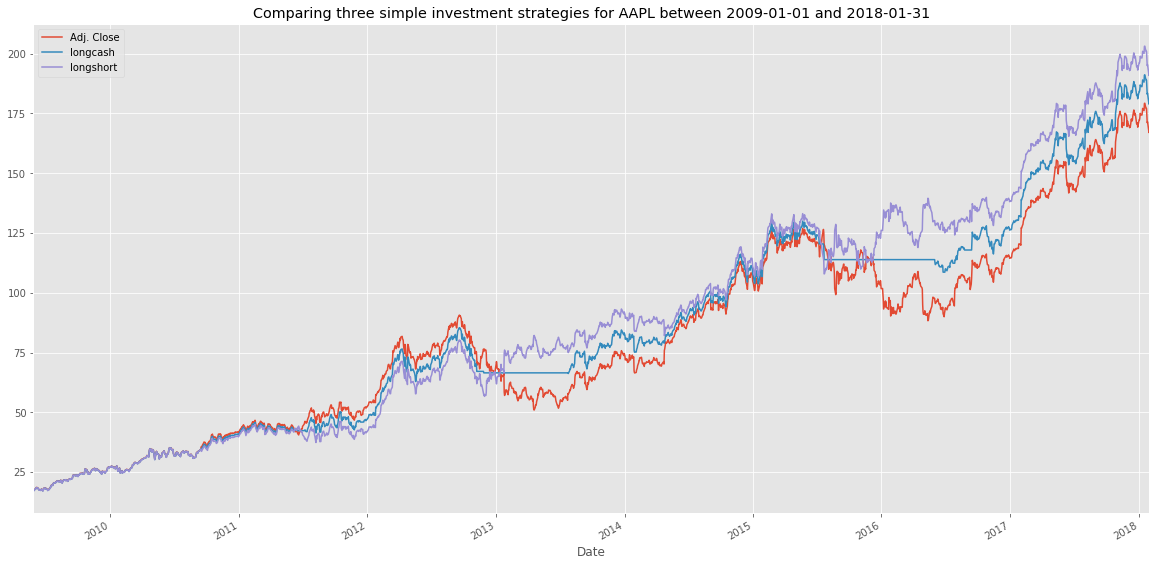

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
return,0.301161,0.252113,-0.087083,7.279833,0.023965,0.034804,1.044344,-0.437964
return longcash,0.312378,0.209140,0.301380,7.954639,0.018032,0.030007,1.311020,-0.224172
return longshort,0.322214,0.246676,0.415107,8.119181,0.020836,0.033990,1.150236,-0.293670


In [427]:
ticker = "AAPL"
start = "2009-01-01"
end = "2018-01-31"

df, df_return = investment_strategies_quandl(ticker=ticker, start=start, end=end)
plot_investment_strategies_quandl(df=df, df_return=df_return, ticker=ticker, start=start, end=end)

### Modifed version where we have to specify the dataframe ourself

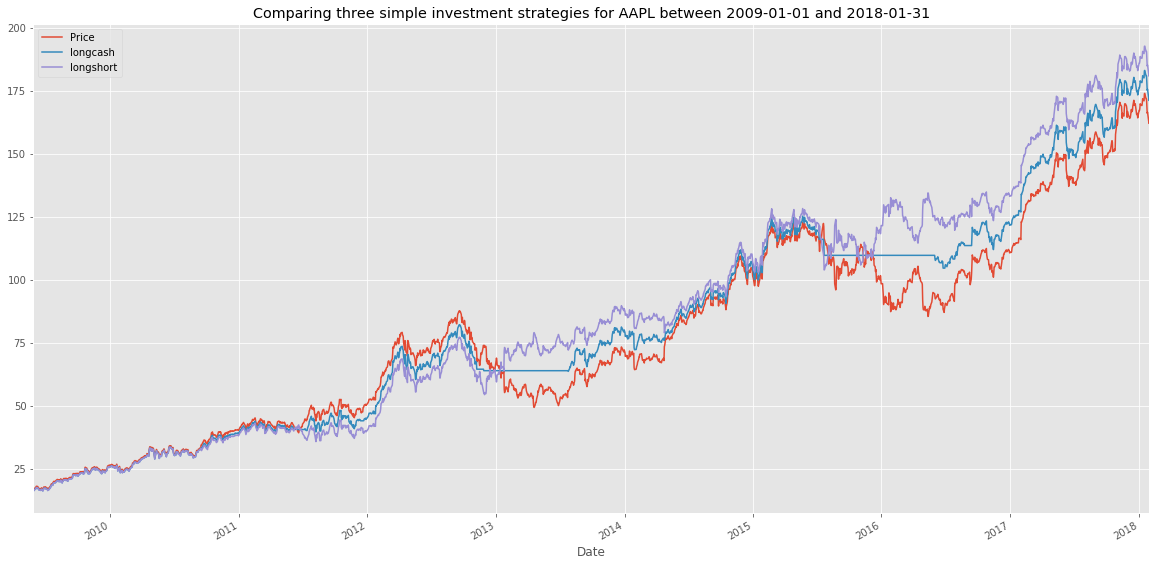

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
return,0.301376,0.251952,-0.088043,7.290714,0.023949,0.034804,1.045840,-0.437972
return longcash,0.314591,0.211035,0.303933,7.970145,0.018183,0.030289,1.309433,-0.225533
return longshort,0.322910,0.248839,0.417071,8.112659,0.021018,0.034299,1.142951,-0.295507


In [428]:
aapl = web.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 1, 31))

aapl.rename(columns={"Adj Close": "Price"}, inplace=True)

ticker = "AAPL"
start = "2009-01-01"
end = "2018-01-31"

df_new, df_return = investment_strategies(df=aapl, ticker=ticker, start=start, end=end)
plot_investment_strategies(df=df_new, df_return=df_return, ticker=ticker, start=start, end=end)

### Use S&P500 index

As we can see, our strategies doesn't work well here

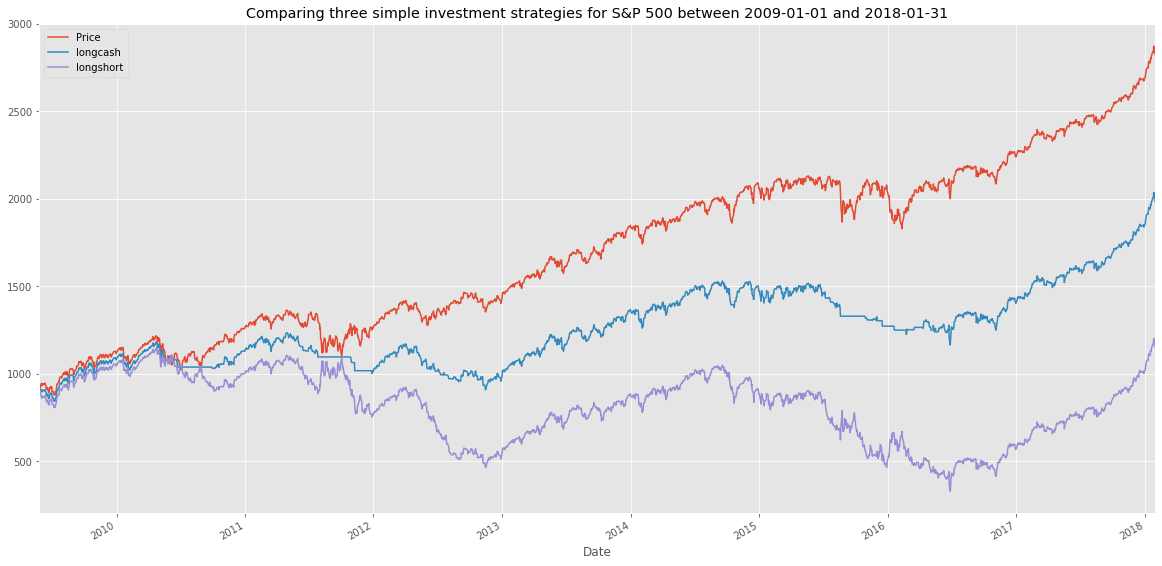

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
return,0.141916,0.148931,-0.373074,7.223032,0.015028,0.022776,0.729656,-0.193882
return longcash,0.096634,0.140618,-0.461740,6.434417,0.014675,0.022416,0.460109,-0.264260
return longshort,0.029775,0.318786,-0.119354,9.356408,0.030805,0.047802,-0.000703,-0.713084


In [429]:
SP500 = web.get_data_yahoo('^GSPC', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 1, 31))

SP500.rename(columns={"Adj Close": "Price"}, inplace=True)

ticker = "S&P 500"
start = "2009-01-01"
end = "2018-01-31"

df_new, df_return = investment_strategies(df=SP500, ticker=ticker, start=start, end=end)
plot_investment_strategies(df=df_new, df_return=df_return, ticker=ticker, start=start, end=end)

### Look at the Moving average plot of the S&P500

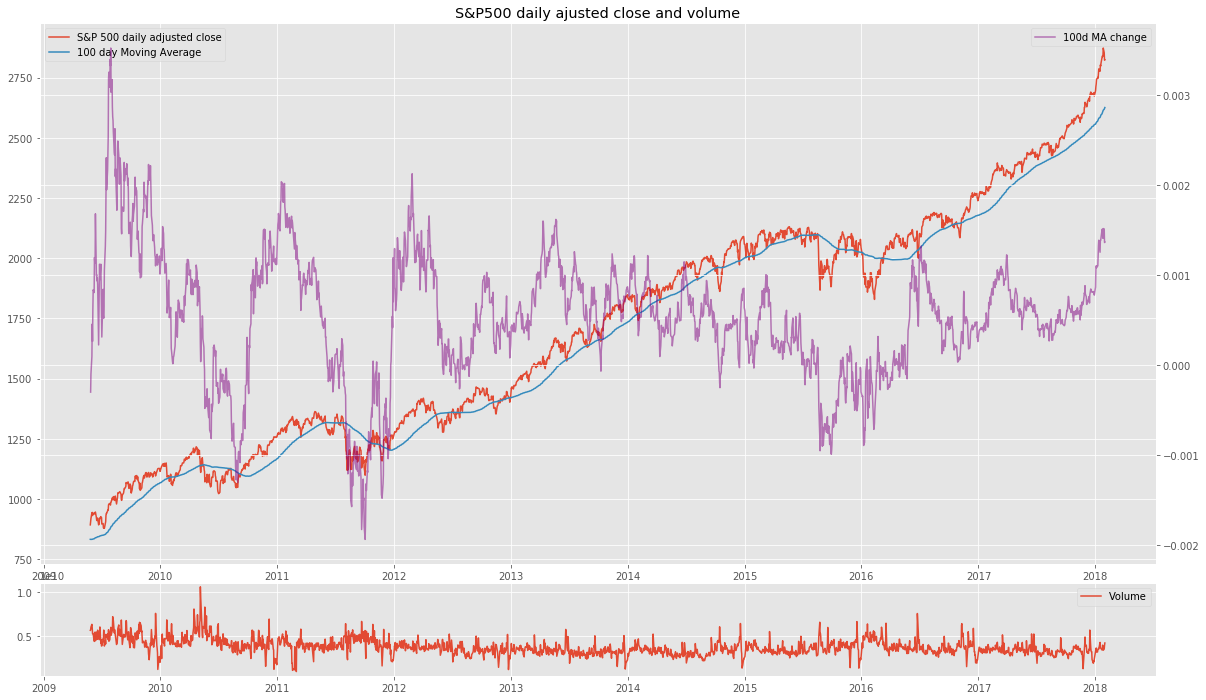

In [430]:
fig = plt.figure(figsize=(20,12))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1,  title="S&P500 daily ajusted close and volume")
ax=ax1.twinx()
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=5, colspan=1, sharex=ax1)

ax1.plot(df_new.index, df_new["Price"])
ax1.plot(df_new.index, df_new["100MA"])
ax.plot(df_new.index, df_new["100MA return"], color = "purple", alpha=0.5)
ax2.plot(df_new.index, df_new["Volume"])
#ax.grid(False)
#ax1.grid(False)
ax1.legend(["S&P 500 daily adjusted close", "100 day Moving Average"])
ax.legend(["100d MA change"])
ax2.legend(["Volume"])

plt.show()

# Further exploration:

For further work we want to optimize the timing of long and short. In general We don't want to change position more frequently than weekly or monthly due to transaction costs. Possible ways to do this could be

* Use past volatility to determine the market condition
* Look at other time frames for the moving averages as well as exponential moving average, or even the Garch model
* Use cross validation to find an optimal slope of the MA that should trigger a change in position